# CSCI 0451: Classifying Palmer Penguins


### Abstract

This post is an exploration of the Palmer Penguins dataset. The dataset contains measurements of penguins from three different species. I will use the dataset to train a machine learning model to classify the species of penguins based on certain measurements. I will primarily be utilizing the  `pandas` library, but I will also make use of the `scikit-learn` library to train a support vector machine (SVM) model on the dataset and the `matplotlib` library to visualize the data and the decision boundaries of the model.


In [53]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


Time to clean the data.

In [54]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)




### Data Exploration

Here are some exploratory visualizations of the data.

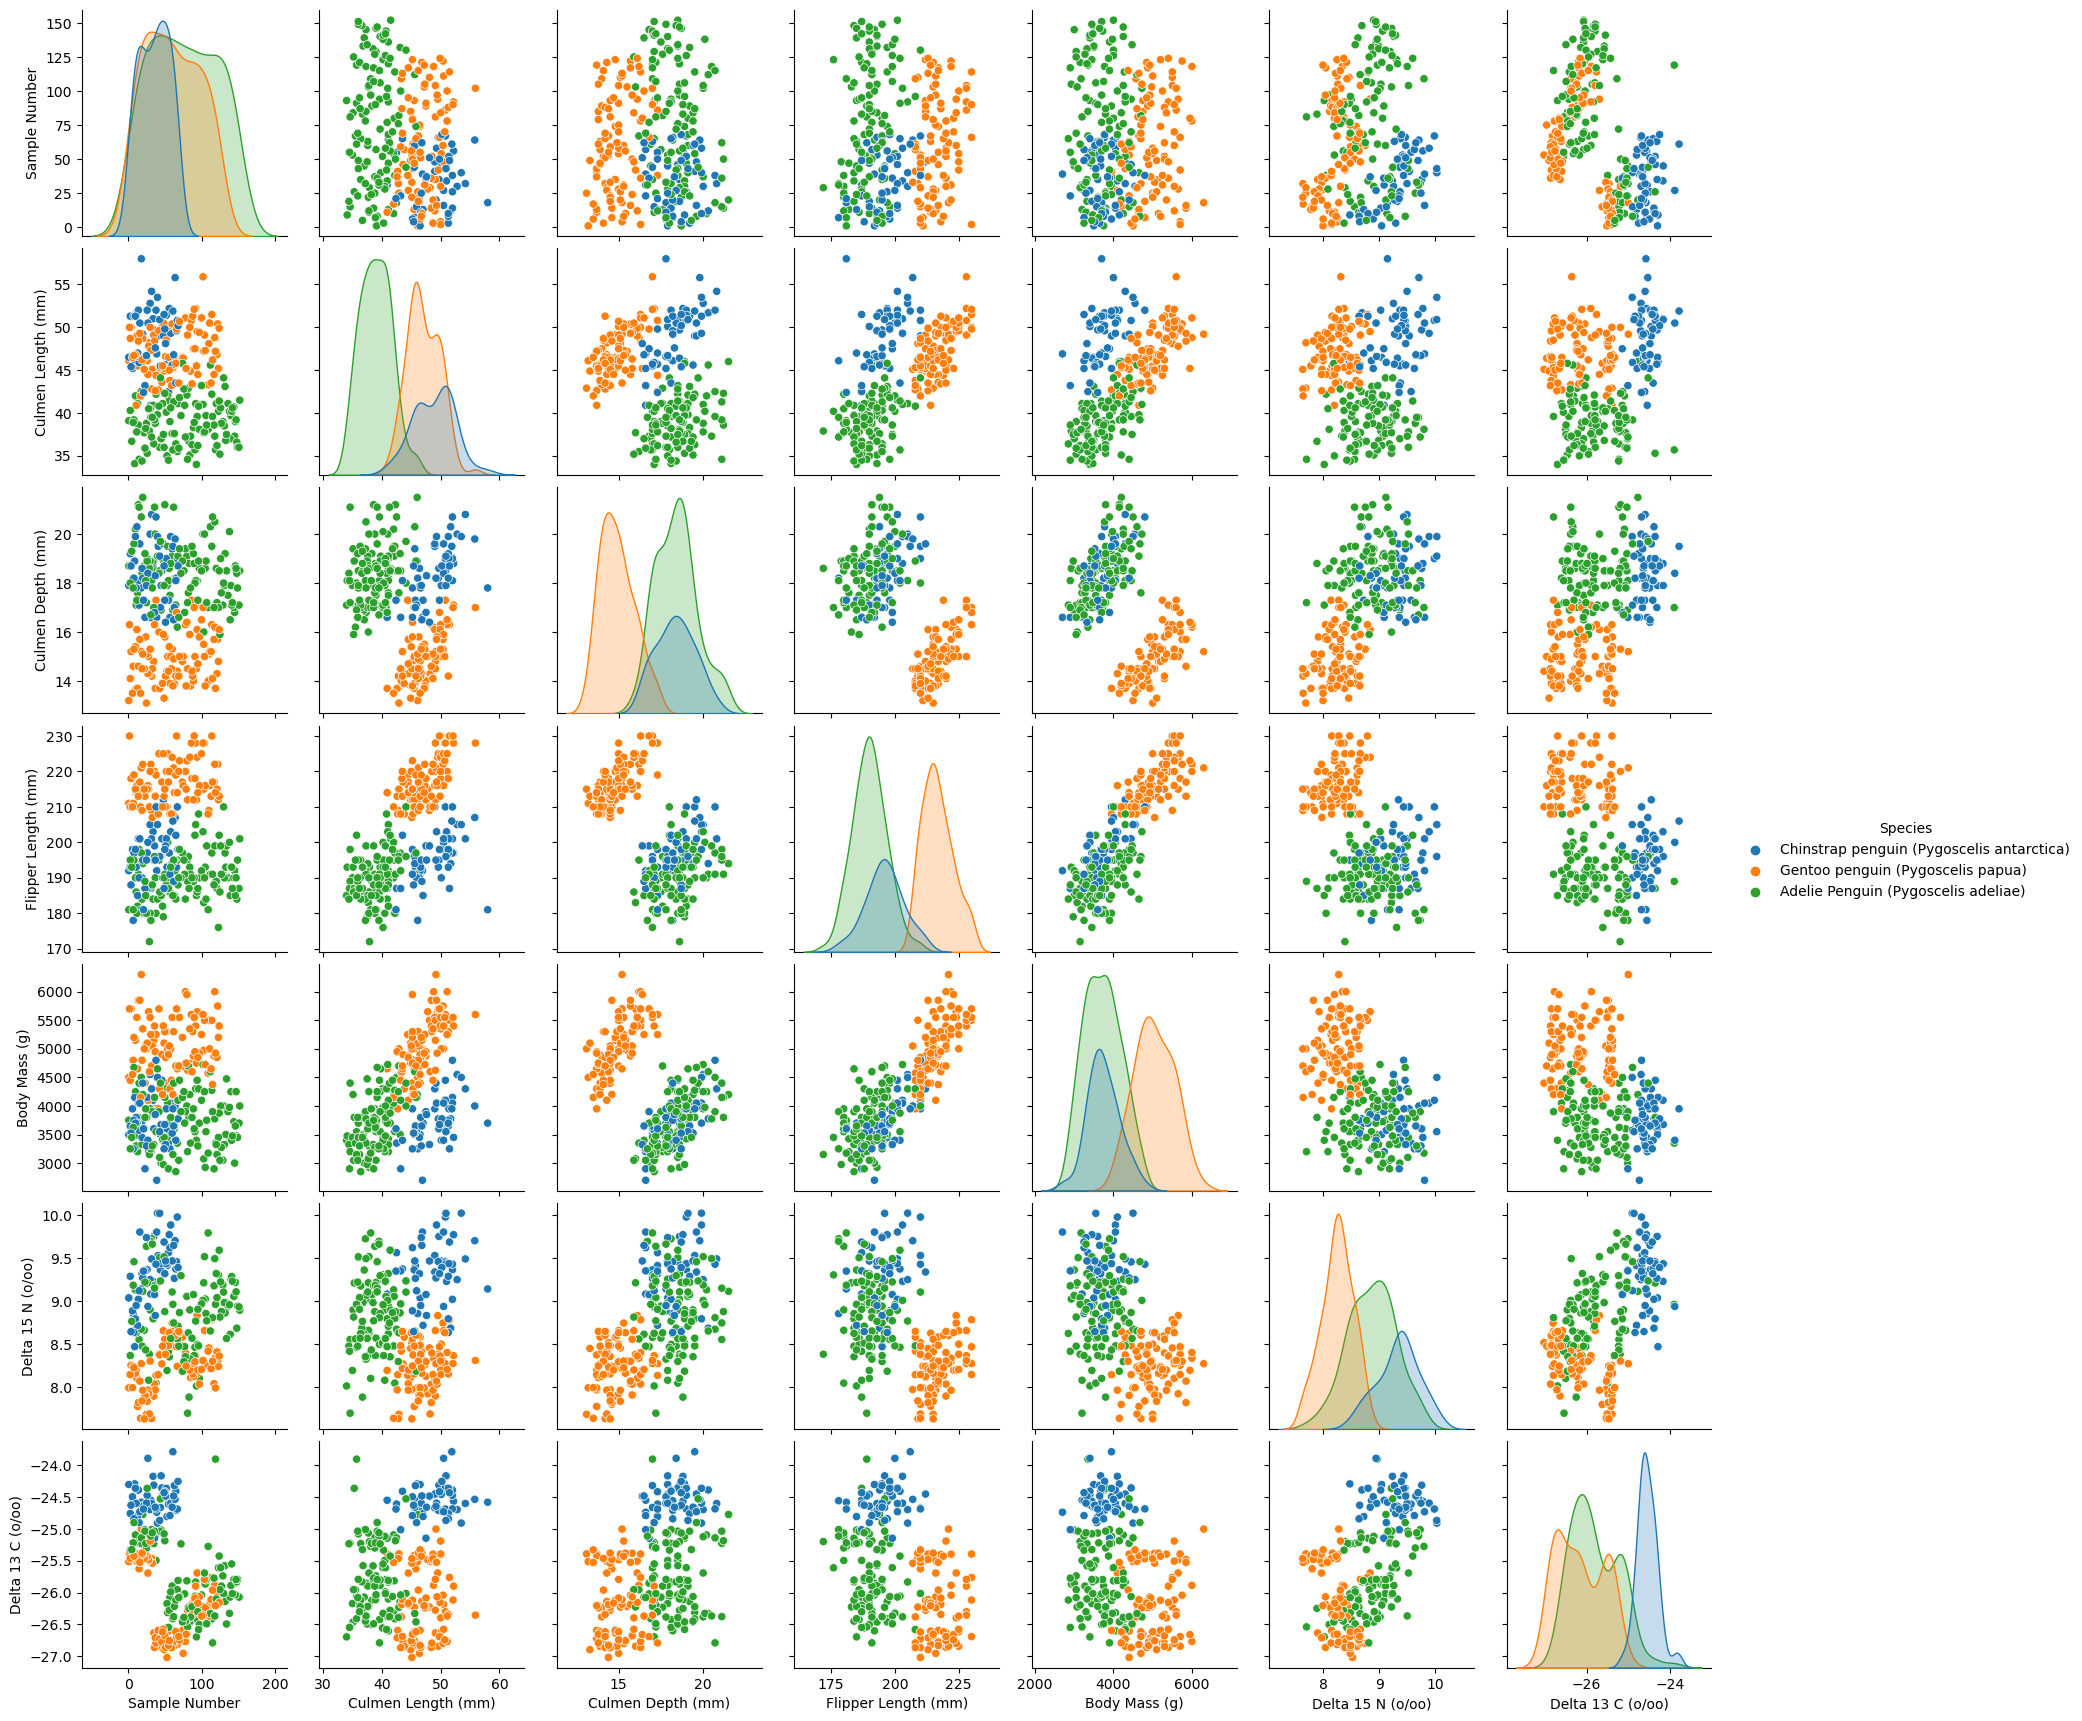

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization 1
# Pairplot of the data, colored by species
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.pairplot(train, hue = "Species")
plt.show()

This gives us a great overview of the data at a glance, but let's take a closer look at some of the features that appear to be the most divisive between species. Seeing as the flipper length does a good job of separating the Gentoo penguins from the other two species, let's select that at one of our initial features.
We also want to look at a metric seems to isolate the two other species. Using the charts on the diagonal, we can see that delta 13 C is good for separating the Chinstraps, and the culmen length is good for separating the Adelies. 

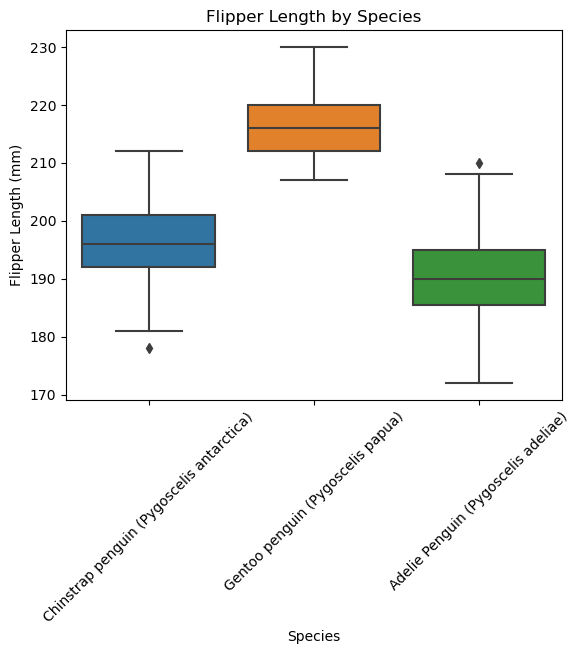

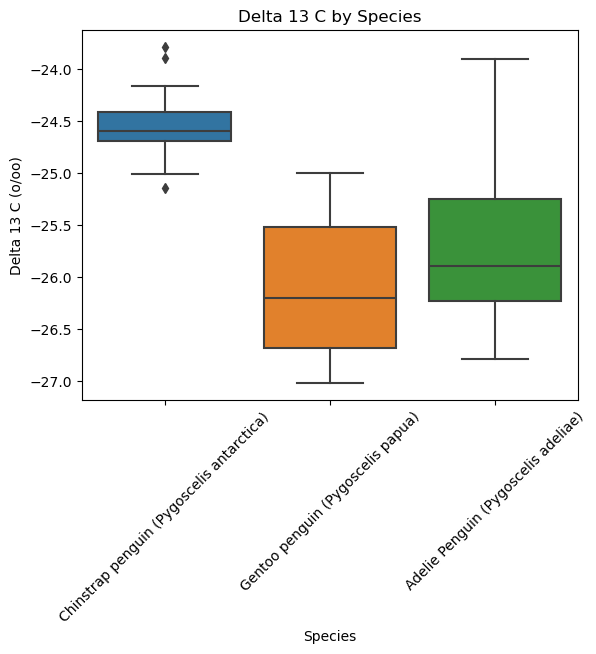

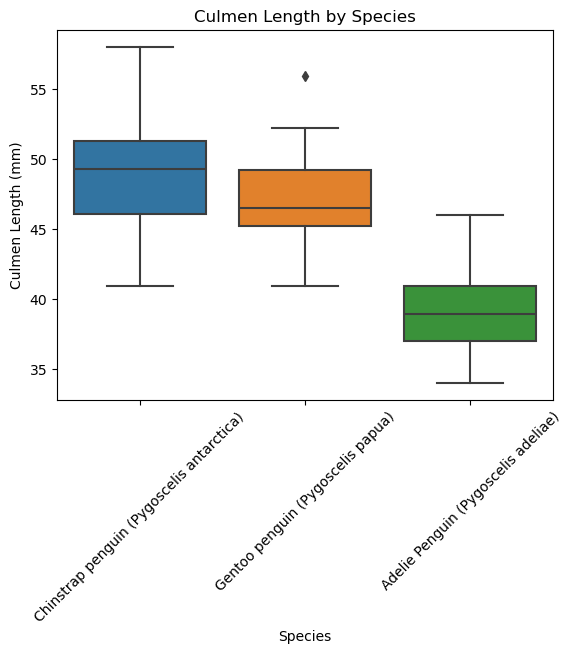

In [56]:
# Visualization 2
# Let's look more at the flipper length, delta 13 c, and culmen length
# flipper length by species
sns.boxplot(data = train, x = "Species", y = "Flipper Length (mm)")
plt.xticks(rotation = 45)
plt.title("Flipper Length by Species")
plt.show()
# delta 13 c by species
sns.boxplot(data = train, x = "Species", y = "Delta 13 C (o/oo)")
plt.xticks(rotation = 45)
plt.title("Delta 13 C by Species")
plt.show()
# culmen length by species
sns.boxplot(data = train, x = "Species", y = "Culmen Length (mm)")
plt.xticks(rotation = 45)
plt.title("Culmen Length by Species")
plt.show()



Now, its time for some tables. We can use the groupby function to get the mean and median values of the flipper length, delta 13 C, and culmen length for each species. This will give us a good idea of the average values for each species, and will help us to see how the species differ in terms of these features.

In [57]:
# Mean values
means = train.groupby("Species")[["Flipper Length (mm)", "Delta 13 C (o/oo)", "Culmen Length (mm)"]].mean()
print("Mean values")
print(means)

Mean values
                                           Flipper Length (mm)  \
Species                                                          
Adelie Penguin (Pygoscelis adeliae)                 190.084034   
Chinstrap penguin (Pygoscelis antarctica)           196.000000   
Gentoo penguin (Pygoscelis papua)                   216.752577   

                                           Delta 13 C (o/oo)  \
Species                                                        
Adelie Penguin (Pygoscelis adeliae)               -25.796897   
Chinstrap penguin (Pygoscelis antarctica)         -24.553401   
Gentoo penguin (Pygoscelis papua)                 -26.149389   

                                           Culmen Length (mm)  
Species                                                        
Adelie Penguin (Pygoscelis adeliae)                 38.970588  
Chinstrap penguin (Pygoscelis antarctica)           48.826316  
Gentoo penguin (Pygoscelis papua)                   47.073196  


In [58]:
# Median values
medians = train.groupby("Species")[["Flipper Length (mm)", "Delta 13 C (o/oo)", "Culmen Length (mm)"]].median()
print("Median values")
print(medians)

Median values
                                           Flipper Length (mm)  \
Species                                                          
Adelie Penguin (Pygoscelis adeliae)                      190.0   
Chinstrap penguin (Pygoscelis antarctica)                196.0   
Gentoo penguin (Pygoscelis papua)                        216.0   

                                           Delta 13 C (o/oo)  \
Species                                                        
Adelie Penguin (Pygoscelis adeliae)                -25.89709   
Chinstrap penguin (Pygoscelis antarctica)          -24.59467   
Gentoo penguin (Pygoscelis papua)                  -26.20455   

                                           Culmen Length (mm)  
Species                                                        
Adelie Penguin (Pygoscelis adeliae)                      38.9  
Chinstrap penguin (Pygoscelis antarctica)                49.3  
Gentoo penguin (Pygoscelis papua)                        46.5  


While these metrics are a great start, it is important to remember that human decision making is not always ideal or feasible. We can instead use some machine learning tools to help us determine the best features to use.

Let's perform an exhaustive search over all possible feature combinations to determine the best features to use for our model. We will use the combinations function from the itertools package for this.


In [59]:
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define the model
model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# Define the features
features = X_train.columns

# Define the number of features to select
n_features = 3

# Perform the search
best_score = 0
best_features = []
for combo in combinations(features, n_features):
  X_train_subset = X_train[list(combo)]
  score = cross_val_score(model, X_train_subset, y_train, cv = 5).mean()
  if score > best_score:
    best_score = score
    best_features = combo

print("Best features: ", best_features)
print("Best score: ", best_score)


Best features:  ('Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex_MALE')
Best score:  0.9844645550527904


Wow! That took a long time (over a minute!). It's important to note that this method will not work for larger datasets, as the number of possible combinations grows exponentially with the number of features. However, for this dataset, it is a feasible method.

Taking a look at the results, we can see that the best features to use are Culmen Length, Culmen Depth, and Sex. Time to train the model.

### Model Time

To start, lets define our Logistic Regression model. We will use the LogisticRegression class from the scikit-learn library to do this.

In [60]:
from sklearn.linear_model import LogisticRegression

# Define the model
model = LogisticRegression(max_iter = 1000)

# Define the features
features = ["Culmen Length (mm)", "Culmen Depth (mm)", "Sex_MALE", "Sex_FEMALE"]

# Train the model
model.fit(X_train[features], y_train)
print("Train Set Score: ", model.score(X_train[features], y_train))

# Let's now evaluate the model on the test set.
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)
print("Test Set Score: ", model.score(X_test[features], y_test))



Train Set Score:  0.9921875
Test Set Score:  0.9852941176470589


Success! Our model has an accuracy of 98% on the test data. This is a great result, but it is important to remember that this is a small dataset, and the model may not perform as well on larger datasets. However, for this dataset, the model is performing very well.

Next up, let's visualize the decision boundaries of the model.

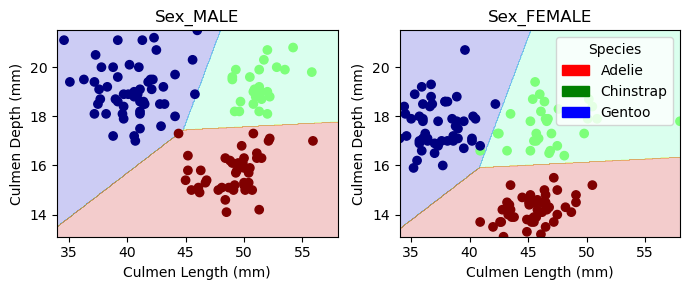

In [61]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # Ensure axarr is a list
    if not isinstance(axarr, np.ndarray):
        axarr = np.array([axarr])

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

plot_regions(model, X_train[features], y_train)

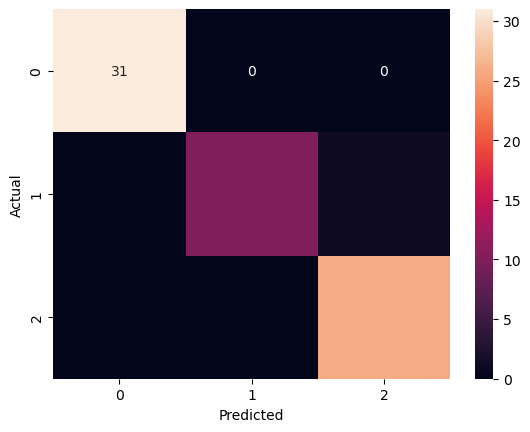

In [62]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test[features])
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = "d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The above confusion matrix indicates that we have pretty great results. We are mostly getting the correct species, with only a few misclassifications. We can see from the graph that the misclassifications are mostly due to special penguin specimens who have outlying features. This is good because it means that our model is likely not overfitting to the training data. Lets verify this using cross-validation.

In [63]:
# cross validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, cv = 5)
scores.mean()
print("Cross Validation Score: ", scores.mean())

Cross Validation Score:  1.0


### Discussion

In this post, I explored the differences between the three species of penguins in the Palmer Penguins dataset. I used the dataset to train a machine learning model to classify the species of penguins based on certain measurements. Some of the measurements were quantitative while others were qualitative. I was able to use the combinations function from the itertools package to determine the best features to use for the model. I then trained a logistic regression model from the scikit-learn library on the dataset and visualized the decision boundaries of the model. The model was highly accurate and performed well on the test data. I also used cross-validation to verify that the model was not overfitting to the training data. Overall, the model performed very well on the dataset, and the results were promising.
